# Bike Rent - Predict demand

Importing libraries

In [59]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt


import warnings
warnings.simplefilter("ignore")


Loading preprocessed dataset and transforming column of date to datetime

In [70]:
og = pd.read_csv('../data/processed/SeoulBikeData2.csv', encoding='cp1252')
df = og.copy()
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.head()

,Date,Rented Bike Count,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Month,Day,WeekDay,WeekDayEncoding
0,2017-12-01,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,0,1,2017,12,1,Friday,5
1,2017-12-01,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,0,1,2017,12,1,Friday,5
2,2017-12-01,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,0,1,2017,12,1,Friday,5
3,2017-12-01,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,0,1,2017,12,1,Friday,5
4,2017-12-01,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,0,1,2017,12,1,Friday,5


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     8760 non-null   datetime64[ns]
 1   Rented Bike Count        8760 non-null   int64         
 2   Hour                     8760 non-null   int64         
 3   Temperature(Â°C)         8760 non-null   float64       
 4   Humidity(%)              8760 non-null   int64         
 5   Wind speed (m/s)         8760 non-null   float64       
 6   Visibility (10m)         8760 non-null   int64         
 7   Solar Radiation (MJ/m2)  8760 non-null   float64       
 8   Rainfall(mm)             8760 non-null   float64       
 9   Snowfall (cm)            8760 non-null   float64       
 10  Seasons                  8760 non-null   object        
 11  Holiday                  8760 non-null   int64         
 12  Functioning Day          8760 non-

Will create another dataset just with days that were possible to rent a bike (Functioning Day = 1)

In [72]:
work = df[df['Functioning Day'] == 1]
work.drop('Functioning Day', inplace=True, axis=1)


In [75]:
work.head()

,Date,Rented Bike Count,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Year,Month,Day,WeekDay,WeekDayEncoding
0,2017-12-01,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,0,2017,12,1,Friday,5
1,2017-12-01,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,0,2017,12,1,Friday,5
2,2017-12-01,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,0,2017,12,1,Friday,5
3,2017-12-01,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,0,2017,12,1,Friday,5
4,2017-12-01,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,0,2017,12,1,Friday,5


Let's start with a heatmap showing the linear correlation between the features 

<AxesSubplot:>

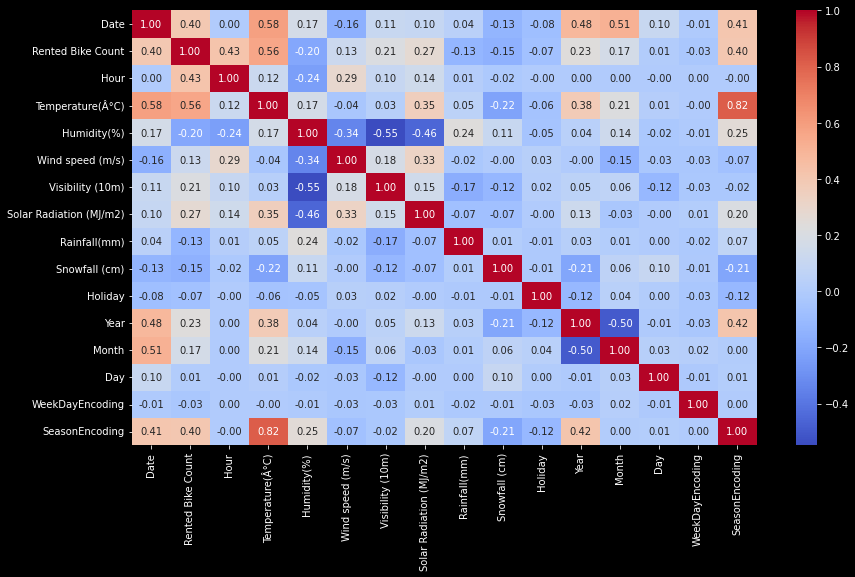

In [83]:
data_plot = work.drop(['WeekDay'], axis=1)

mapping_dictDay = {'Winter': 0,'Autumn': 1,'Spring': 2,'Summer': 3}
data_plot['SeasonEncoding'] = data_plot['Seasons'].map(mapping_dictDay)
data_plot.drop('Seasons', inplace=True, axis=1)

plt.figure(figsize=(14, 8))
sns.heatmap(data_plot.corr(), cmap='coolwarm', annot=True, fmt='.2f')

Considerable correlations with our target: Date, Hour, Temperature and Seasons


## Trends over the Year
This section dives into the big picture, examining trends and patterns across the entire year, identifying seasonal variations and overall performance.

Let's group the dates and calculate: temperature mean and sum of rented bikes

In [85]:
data_plot = work[['Date', 'Temperature(Â°C)', 'Rented Bike Count', 'Seasons']].groupby('Date', axis=0).agg(
    {
        'Temperature(Â°C)': lambda x: x.mean(),
        'Rented Bike Count': lambda x: x.sum(),
        'Seasons': lambda x: x.mode() 
    }
)
data_plot = data_plot.reset_index()
data_plot

,Date,Temperature(Â°C),Rented Bike Count,Seasons
0,2017-12-01,-2.454167,9539,Winter
1,2017-12-02,1.325000,8523,Winter
2,2017-12-03,4.875000,7222,Winter
3,2017-12-04,-0.304167,8729,Winter
4,2017-12-05,-4.458333,8307,Winter
...,...,...,...,...
348,2018-11-26,6.320833,17162,Autumn
349,2018-11-27,7.066667,16282,Autumn
350,2018-11-28,5.304167,16524,Autumn
351,2018-11-29,3.304167,16423,Autumn


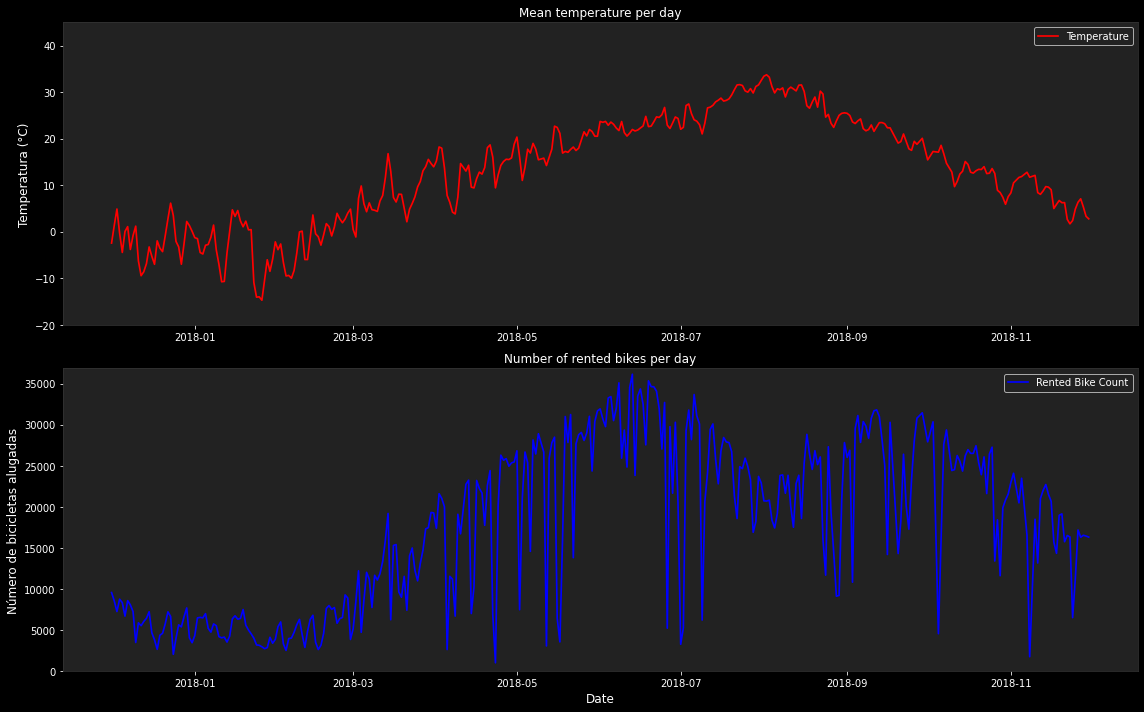

In [22]:
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = '#222222'
plt.rcParams['axes.edgecolor'] = '#333333'

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot temperature data
ax1.plot(data_plot["Date"], data_plot["Temperature(Â°C)"], color="red", label="Temperature", linewidth=1.7)
ax1.set_ylabel("Temperatura (°C)", size=12)
ax1.set_ylim(-20, 45)
ax1.set_title("Mean temperature per day")
ax1.legend()

# Plot rented bike count data
ax2.plot(data_plot["Date"], data_plot["Rented Bike Count"], color="blue", label="Rented Bike Count", linewidth=1.7)
ax2.set_ylabel("Número de bicicletas alugadas", size=12)
ax2.set_ylim(0, np.max(data_plot['Rented Bike Count'])+700)
ax2.set_xlabel("Date", size=12)
ax2.set_title("Number of rented bikes per day")
ax2.legend()

# Overall figure adjustments
plt.tight_layout()

# Show the plot
plt.show()


Anomalies in bike rental data reveal days with substantially lower usage compared to the overall trend. Let's take a look:

In [27]:
date_list = data_plot[(data_plot['Date'] > '2018-03-01') & (data_plot['Rented Bike Count'] < 10000)]['Date'].to_list()

# Filter 'df' based on the converted date list and the 'Rented Bike Count' condition
filtered_df = df[df['Date'].isin(date_list)]
filtered_df.head()


,Date,Rented Bike Count,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(Â°C),Solar Radiation (MJ/m2),Rainfall(mm),...,Functioning Day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Year,Month,Day,WeekDay,WeekDayEncoding
2184,2018-03-02,156,0,-4.3,53,2.6,1334,-12.4,0.0,0.0,...,1,0,1,0,0,2018,3,2,Friday,5
2185,2018-03-02,108,1,-4.6,52,2.1,1372,-12.9,0.0,0.0,...,1,0,1,0,0,2018,3,2,Friday,5
2186,2018-03-02,71,2,-5.3,52,1.2,1434,-13.6,0.0,0.0,...,1,0,1,0,0,2018,3,2,Friday,5
2187,2018-03-02,49,3,-5.7,50,1.7,1559,-14.4,0.0,0.0,...,1,0,1,0,0,2018,3,2,Friday,5
2188,2018-03-02,47,4,-5.8,48,1.5,1552,-15.0,0.0,0.0,...,1,0,1,0,0,2018,3,2,Friday,5


In [ ]:
work.describe()

,Rented Bike Count,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(Â°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Year,Month,Day,WeekDayEncoding
count,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.00000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000
mean,729.156999,11.507029,12.771057,58.147194,1.725883,1433.873479,3.944997,0.567868,0.14912,0.077685,0.048198,0.228825,0.255168,0.260839,0.255168,2017.912109,6.438984,15.840992,4.009687
std,642.351166,6.920899,12.104375,20.484839,1.034281,609.051229,13.242399,0.868245,1.12554,0.444063,0.214198,0.420101,0.435982,0.439118,0.435982,0.283154,3.452362,8.767785,2.008583
min,2.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,1.000000
25%,214.000000,6.000000,3.000000,42.000000,0.900000,935.000000,-5.100000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,3.000000,8.000000,2.000000
50%,542.000000,12.000000,13.500000,57.000000,1.500000,1690.000000,4.700000,0.010000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2018.000000,6.000000,16.000000,4.000000
75%,1084.000000,18.000000,22.700000,74.000000,2.300000,2000.000000,15.200000,0.930000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2018.000000,9.000000,23.000000,6.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.00000,8.800000,1.000000,1.000000,1.000000,1.000000,1.000000,2018.000000,12.000000,31.000000,7.000000


In [ ]:
filtered_df.describe()

,Rented Bike Count,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(Â°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Year,Month,Day,WeekDayEncoding
count,624.000000,624.00000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.000000,624.0,624.0,624.000000,624.000000,624.000000,624.0,624.0,624.000000,624.000000,624.00000
mean,251.546474,11.50000,13.061538,78.677885,1.634135,1098.793269,8.869391,0.196282,1.233013,0.126122,0.0,1.0,0.115385,0.653846,0.230769,0.0,2018.0,5.346154,13.192308,4.00000
std,265.598312,6.92774,7.890197,21.074288,0.952485,692.259912,10.444277,0.404478,3.383057,0.829419,0.0,0.0,0.319742,0.476125,0.421663,0.0,0.0,2.497264,8.729291,2.11393
min,2.000000,0.00000,-6.600000,21.000000,0.000000,33.000000,-18.100000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.0,2018.0,3.000000,1.000000,1.00000
25%,43.000000,5.75000,7.275000,64.000000,0.900000,453.000000,1.375000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,0.0,2018.0,3.000000,5.000000,2.00000
50%,151.500000,11.50000,11.800000,88.000000,1.500000,957.000000,8.750000,0.000000,0.000000,0.000000,0.0,1.0,0.000000,1.000000,0.000000,0.0,2018.0,4.500000,13.000000,4.00000
75%,398.000000,17.25000,20.825000,96.000000,2.200000,1922.500000,19.325000,0.230000,1.000000,0.000000,0.0,1.0,0.000000,1.000000,0.000000,0.0,2018.0,7.000000,21.000000,6.00000
max,1841.000000,23.00000,27.400000,98.000000,5.000000,2000.000000,24.500000,2.830000,35.000000,8.800000,0.0,1.0,1.000000,1.000000,1.000000,0.0,2018.0,11.000000,29.000000,7.00000


As we can see, the days with lower bike rental are, in general:
- more humid
- lower solar radiation
- rainy and snowy days
- majority in spring season (this can mean nothing)

<AxesSubplot:xlabel='Seasons', ylabel='Rented Bike Count'>

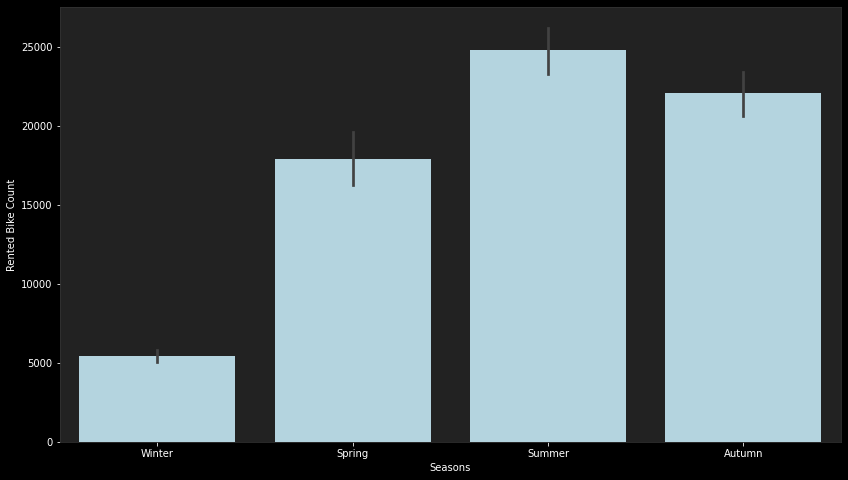

In [87]:
plt.figure(figsize=(14, 8))
sns.barplot(data=data_plot, x='Seasons', y='Rented Bike Count', color='lightblue')

## Trends along the week
This section delves into the intricate patterns of bike rentals across a typical week. 

In [42]:
weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

data_plot = work.copy() 
data_plot['WeekDay'] = pd.Categorical(data_plot['WeekDay'], categories=weekday_order, ordered=True)
data_plot = data_plot.sort_values('WeekDay')



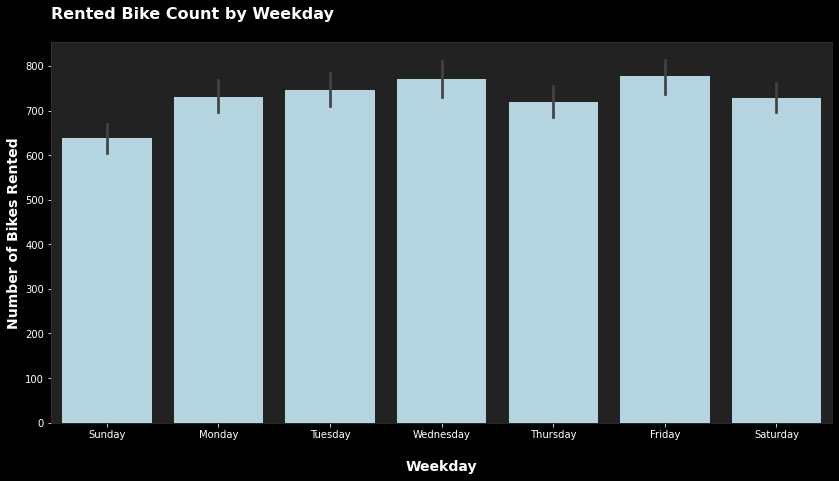

In [58]:
plt.figure(figsize=(14, 7))  

sns.barplot(data=data_plot, x='WeekDay', y='Rented Bike Count', color='lightblue')

plt.title("Rented Bike Count by Weekday\n", loc='left', fontsize=16, fontweight='bold')  # Title
plt.xlabel("\nWeekday", fontsize=14, fontweight='bold')  # X-axis label
plt.ylabel("Number of Bikes Rented", fontsize=14, fontweight='bold')  # Y-axis label


plt.show()  # Display the chart


In [39]:
work[work['WeekDay'] == 'Sunday']['Rented Bike Count'].mean()

637.4133986928105

<AxesSubplot:xlabel='Hour', ylabel='Rented Bike Count'>

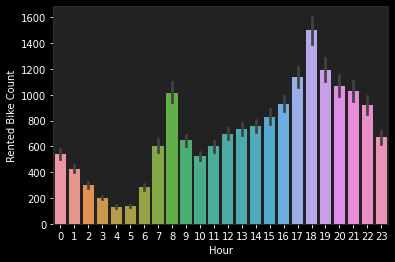

In [ ]:
sns.barplot(data=df, x='Hour', y='Rented Bike Count')